# Clasificador de imágenes

In [ ]:
!git clone https://github.com/DavidReveloLuna/API_DeepLearning.git

Cloning into 'API_DeepLearning'...
remote: Enumerating objects: 29774, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29774 (delta 12), reused 14 (delta 4), pack-reused 29745
Receiving objects: 100% (29774/29774), 605.55 MiB | 37.11 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración de parámetros

In [ ]:
width_shape = 224
height_shape = 224
num_classes = 10
epochs = 50
batch_size = 32 

# Path de dataset

In [ ]:
train_data_dir = '/content/API_DeepLearning/dataset/train'  
validation_data_dir = '/content/API_DeepLearning/dataset/valid'

# Generador de imágenes (entrenamiento y validación)

In [ ]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')




Found 1490 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Entrenamiento de modelo VGG16

In [ ]:
nb_train_samples = 1490
nb_validation_samples = 50

image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)

for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

model_history = custom_vgg_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
46/46 [==============================] - 22s 441ms/step - loss: 4.3250 - accuracy: 0.0341 - val_loss: 3.9406 - val_accuracy: 0.0625
Epoch 2/50
46/46 [==============================] - 19s 418ms/step - loss: 4.2164 - accuracy: 0.0341 - val_loss: 4.3524 - val_accuracy: 0.0312
Epoch 3/50
46/46 [==============================] - 18s 401ms/step - loss: 4.0942 - accuracy: 0.0364 - val_loss: 3.8946 - val_accuracy: 0.0312
Epoch 4/50
46/46 [==============================] - 19s 411ms/step - loss: 3.9956 - accuracy: 0.0491 - val_loss: 4.1670 - val_accuracy: 0.0312
Epoch 5/50
46/46 [==============================] - 20s 423ms/step - loss: 3.9921 - accuracy: 0.0410 - val_loss: 3.5188 - val_accuracy: 0.0312
Epoch 6/50
46/46 [==============================] - 18s 398ms/step - loss: 3.8551 - accuracy: 0.0581 - val_loss: 4.0115 - val_accuracy: 0.0000e+00
Epoch 7/50
46/46 [==============================] - 18s 397ms/step - loss: 3.8624 - accuracy: 0.0564 - val_loss: 3.4864 - val_accuracy: 0.

# Grabar modelo en disco

In [ ]:
custom_vgg_model.save("/content/API_DeepLearning/models/model_VGG16.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [ ]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

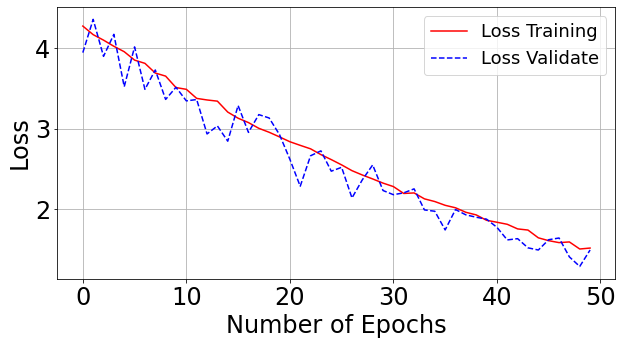

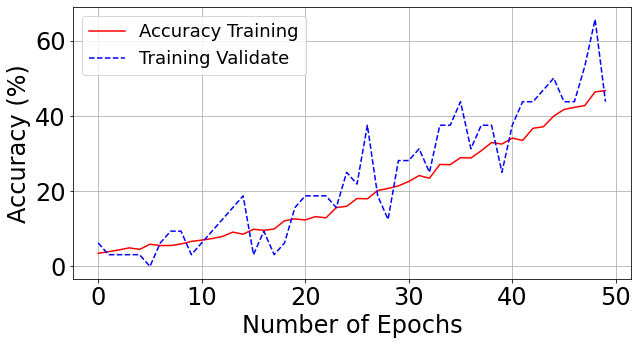

In [ ]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

AMERICAN AVOCET


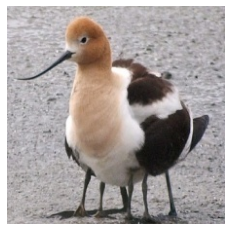

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']

modelt = load_model("/content/API_DeepLearning/models/model_VGG16.h5")
#modelt = custom_vgg_model

imaget_path = "/content/API_DeepLearning/ImagenPrueba.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()